In [147]:
import numpy as np
from sklearn.metrics import classification_report, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cross_validation import train_test_split

import pandas as pd
from pickle import load, dump

from keras import metrics
import keras.backend as K
from keras.layers import *
from keras.layers.core import *
from keras.layers.recurrent import *
from keras.layers.merge import *
from keras.layers.convolutional import *
from keras.layers.embeddings import *
from keras.layers.wrappers import *
from keras.layers.normalization import *
from keras.layers.advanced_activations import *
from keras.models import *
from keras.callbacks import *
from keras.utils.vis_utils import *
from keras.utils import *

from IPython.display import SVG, Image
import matplotlib.pyplot as plt

In [130]:
def read_data(path):
    Xs, Ys = pd.read_pickle(path)
    

    Xtrain, Xvalid, Xtest = Xs[:,:5725], Xs[:,5725:5725*2], Xs[:,5725*2:]
    
    Ys = np.concatenate([to_categorical(Ys[rowid])[None,:,:] for rowid in range(len(Ys))])
    Ytrain, Yvalid, Ytest = Ys[:,:5725], Ys[:,5725:5725*2], Ys[:,5725*2:]

    return Xtrain, Xvalid, Xtest, Ytrain, Yvalid, Ytest

In [131]:
Xtrain, Xvalid, Xtest, Ytrain, Yvalid, Ytest = read_data("../data/input.pkl")
Xtrain = np.concatenate([Xtrain, Xtest], axis=1)
Ytrain = np.concatenate([Ytrain, Ytest], axis=1)

In [132]:
print(f"train, X size: {Xtrain.shape}, Y size: {Ytrain.shape}")
print(f"test, X size: {Xvalid.shape}, Y size: {Yvalid.shape}")

train, X size: (28, 14070, 100, 5), Y size: (28, 14070, 2)
test, X size: (28, 5725, 100, 5), Y size: (28, 5725, 2)


# Model definition

In [133]:
%%time 
# channel last
input_shape = (length_bin, num_marks)
input = Input(shape=input_shape)

nn = Conv1D(50, 10, padding='same', activation="relu")(input)
nn = BatchNormalization()(nn)
nn = MaxPooling1D(5, strides=5, padding='same')(nn)
nn = Dropout(0.5)(nn)
nn = Conv1D(50, 10, padding='same', activation="relu")(nn)
nn = BatchNormalization()(nn)
nn = MaxPooling1D(5, strides=5, padding='same')(nn)
nn = Dropout(0.5)(nn)
nn = Conv1D(50, 10, padding='same', activation="relu")(nn)
nn = BatchNormalization()(nn)
nn = MaxPooling1D(5, strides=5, padding='same')(nn)
nn = Dropout(0.5)(nn)
nn = Flatten()(nn)
nn = Dense(625, activation="relu")(nn)
nn = Dense(125, activation="relu")(nn)
nn = Dense(2, activation="softmax")(nn)


clf = Model(inputs=input, outputs=nn)
clf.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

CPU times: user 572 ms, sys: 208 ms, total: 780 ms
Wall time: 807 ms
Parser   : 1.76 s


In [145]:
a = model_to_dot(clf).create(prog='dot', format='png')

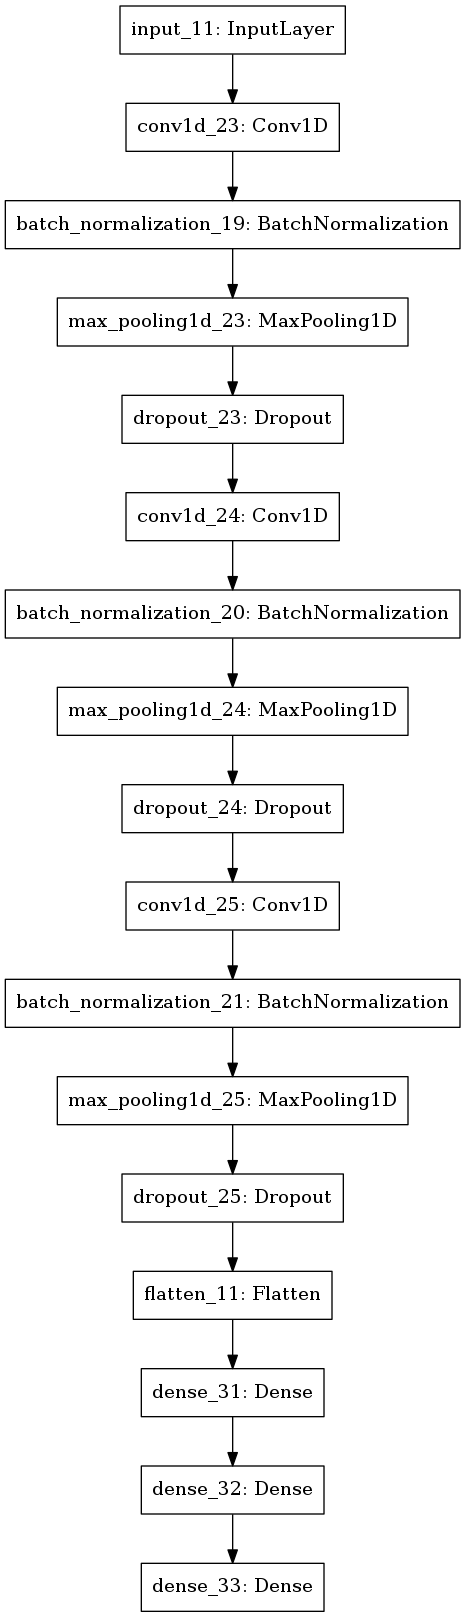

In [148]:
Image(a)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 100, 5)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 100, 50)           2550      
_________________________________________________________________
batch_normalization_19 (Batc (None, 100, 50)           200       
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 20, 50)            0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 20, 50)            25050     
_________________________________________________________________
batch_normalization_20 (Batc (None, 20, 50)            200       
__________

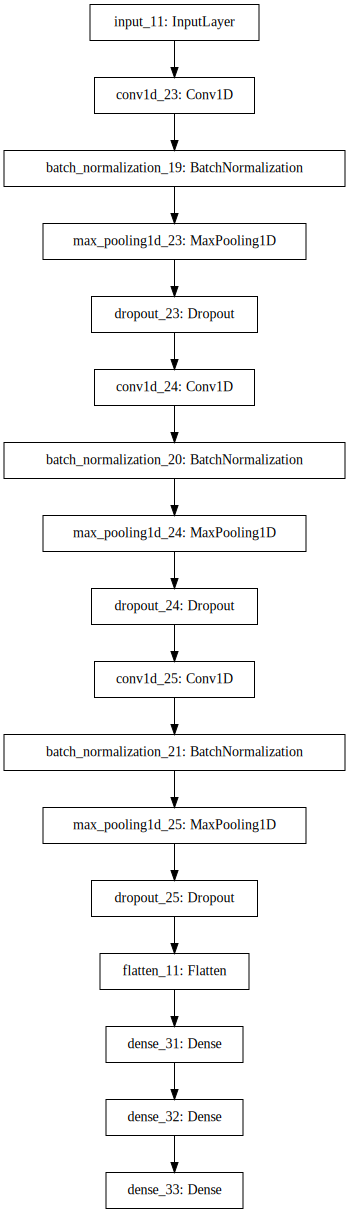

In [143]:
clf.summary()
SVG(model_to_dot(clf).create(prog='dot', format='svg'))

In [139]:
run_name = "ourchrome 002"
tb = TensorBoard(log_dir=f"../log/{run_name}", batch_size=32, write_graph=True)
checkpointer = ModelCheckpoint(filepath=f"../model/{run_name}.h5", verbose=1, save_best_only=True, monitor="val_acc")
stopper = EarlyStopping(monitor="val_acc", patience=3)

In [140]:
epigenome = 1
clf.fit(
    Xtrain[epigenome],
    Ytrain[epigenome],
    batch_size=2000,
    callbacks = [tb, checkpointer],
    epochs=1000,
    shuffle=True,
    validation_data=(Xvalid[epigenome], Yvalid[epigenome]),
    verbose=0)

Epoch 00000: val_acc improved from -inf to 0.64803, saving model to ../model/ourchrome 002.h5
Epoch 00001: val_acc did not improve
Epoch 00002: val_acc improved from 0.64803 to 0.64821, saving model to ../model/ourchrome 002.h5
Epoch 00003: val_acc improved from 0.64821 to 0.68978, saving model to ../model/ourchrome 002.h5
Epoch 00004: val_acc did not improve
Epoch 00005: val_acc did not improve
Epoch 00006: val_acc did not improve
Epoch 00007: val_acc did not improve
Epoch 00008: val_acc improved from 0.68978 to 0.69013, saving model to ../model/ourchrome 002.h5
Epoch 00009: val_acc improved from 0.69013 to 0.69852, saving model to ../model/ourchrome 002.h5
Epoch 00010: val_acc did not improve
Epoch 00011: val_acc did not improve
Epoch 00012: val_acc improved from 0.69852 to 0.71651, saving model to ../model/ourchrome 002.h5
Epoch 00013: val_acc did not improve
Epoch 00014: val_acc did not improve
Epoch 00015: val_acc did not improve
Epoch 00016: val_acc did not improve
Epoch 00017: v

KeyboardInterrupt: 

In [ ]:
predY = clf.predict(Xtest[epigenome])
print(classification_report(Ytest[epigenome][:,1], predY[:,1]> 0.5))